In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 561 kB/s 
     |████████████████████████████████| 453 kB 49.5 MB/s 


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (11.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [3]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-23 14:43:13--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=XXyy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from konlpy.tag import Okt
import os
from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
import re

plt.rc('font', family='Malgun Gothic')
train_df = pd.read_excel('/content/drive/MyDrive/sentiment_analysis.xlsx')
train_df.head()

번호  value  연령  성별        상황키워드    신체질환 감정_대분류 감정_소분류  \
0  24070      1  청년  여성   진로, 취업, 직장    해당없음     기쁨   신이 난   
1  27879      1  청년  여성   연애, 결혼, 출산    해당없음     기쁨   신이 난   
2  51471      1  중년  여성  직장, 업무 스트레스    해당없음     불안     불안   
3   7140      1  노년  남성         대인관계  만성질환 유     슬픔   염세적인   
4  39663      1  노년  남성           재정  만성질환 유     슬픔    마비된   

                                               사람문장1  \
0                                    지금 난 기분이 너무 좋아.   
1                                  나도 조카가 생겨! 너무 기뻐.   
2                            거래처와의 다음 계약이 무산될까봐 불안해.   
3  당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...   
4                        노년에 재정적으로 이루어 놓은게 없어서 걱정이야.   

                                      시스템응답1  \
0                굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?   
1             정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?   
2  많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?   
3  몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.   
4                   나이들어 재정적으로 어려워서 걱정되시는군요.   

                                      사람문장2                          시스템응답2  \
0               오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.  그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?   
1     응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.            언니에게 꽃을 선물하려고 하시는군요.   
2               딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.     계약을 성공적으로 마무리하실 수 있기를 기원해요.   
3  젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.   지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?   
4                                 정말이지 막막해.   막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.   

                                               사람문장3  \
0                        그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.   
1                                                NaN   
2                                                NaN   
3  아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...   
4                                                NaN   

                          시스템응답3  
0  집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.  
1                            NaN  
2                            NaN  
3       아내와의 대화로 기분이 나아졌으면 좋겠어요.  
4                            NaN

In [6]:
train_df.shape

(74856, 14)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74856 entries, 0 to 74855
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   번호      74856 non-null  int64 
 1   value   74856 non-null  int64 
 2   연령      74856 non-null  object
 3   성별      74856 non-null  object
 4   상황키워드   74856 non-null  object
 5   신체질환    74856 non-null  object
 6   감정_대분류  74856 non-null  object
 7   감정_소분류  74856 non-null  object
 8   사람문장1   74856 non-null  object
 9   시스템응답1  74856 non-null  object
 10  사람문장2   74856 non-null  object
 11  시스템응답2  74855 non-null  object
 12  사람문장3   49660 non-null  object
 13  시스템응답3  49654 non-null  object
dtypes: int64(2), object(12)
memory usage: 8.0+ MB


In [8]:
train_df.fillna('', inplace = True)
train_df.drop(['번호', 'value' ,'연령', '성별', '상황키워드', '신체질환', '감정_소분류'],axis=1,inplace = True)

In [9]:
sentimential_list = {'행복' : 0, '기쁨': 0, '분노' : 1, '불안' : 1, '당황' : 2, '슬픔' : 2, '상처' : 2}
train_df['label'] = train_df['감정_대분류'].map(sentimential_list)
train_df.head()

감정_대분류                                              사람문장1  \
0     기쁨                                    지금 난 기분이 너무 좋아.   
1     기쁨                                  나도 조카가 생겨! 너무 기뻐.   
2     불안                            거래처와의 다음 계약이 무산될까봐 불안해.   
3     슬픔  당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...   
4     슬픔                        노년에 재정적으로 이루어 놓은게 없어서 걱정이야.   

                                      시스템응답1  \
0                굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?   
1             정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?   
2  많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?   
3  몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.   
4                   나이들어 재정적으로 어려워서 걱정되시는군요.   

                                      사람문장2                          시스템응답2  \
0               오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.  그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?   
1     응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.            언니에게 꽃을 선물하려고 하시는군요.   
2               딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.     계약을 성공적으로 마무리하실 수 있기를 기원해요.   
3  젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.   지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?   
4                                 정말이지 막막해.   막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.   

                                               사람문장3  \
0                        그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.   
1                                                      
2                                                      
3  아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...   
4                                                      

                          시스템응답3  label  
0  집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.      0  
1                                     0  
2                                     1  
3       아내와의 대화로 기분이 나아졌으면 좋겠어요.      2  
4                                     2

텍스트 전처리 : text를 모든 문장을 합쳐서 처리



In [10]:
train_df['text'] = train_df['사람문장1'] + ' ' + train_df['시스템응답1']  + ' ' + train_df['사람문장2'].map(str) + ' ' + train_df['시스템응답2']  + ' ' +train_df['사람문장3']  + ' ' + train_df['시스템응답3']
train_df['text'] = train_df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [11]:
train_df.drop_duplicates(subset = ['text'], inplace = True) #중복 제거

In [12]:
print(sum(map(len, train_df['text'])) / len(train_df['text'])) # 평균 글자 수

156.32599047849592


In [13]:
import random
import pickle
import re

wordnet = {}
with open("/content/drive/MyDrive/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)

In [14]:
# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',str(line))

	return parseText

In [15]:
########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words):
  new_words = words.copy()
  random_word_list = list(set([word for word in words]))
  random.shuffle(random_word_list)
  num_replaced = 0
  sentence = ""
  for random_word in random_word_list:
    synonyms = get_synonyms(random_word)
    if len(synonyms) >= 1:
      synonym = list(synonyms)
      new_words = [synonym[random.randrange(len(synonyms))] if word == random_word else word for word in new_words]
      sentence += ' '.join(new_words) + "\n"
      num_replaced += 1


  return sentence

In [16]:
def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			synomyms.append(syn)
	except:
		pass

	return synomyms 

In [22]:
def EDA(sentence, alpha_sr = 0.1, num_aug = 4):
  okt = Okt()
  sentence = get_only_hangul(sentence)
  morphs = okt.morphs(sentence)
  num_of_morphs = len(morphs)

  augmented_sentences = []
  num_new_per_technique = num_aug

  for i in range(num_new_per_technique):
    a_words = synonym_replacement(morphs)
    augmented_sentences = a_words.split('\n')

    augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
    '''
    if num_aug >= 1:
      augmented_sentences = augmented_sentences[:num_aug]
    else:
      keep_prob = num_aug / len(augmented_sentences)
      augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]'''

    augmented_sentences.append(sentence)
    return [sentence for sentence in list(set(augmented_sentences)) if sentence is not ""]

In [18]:
train_df

감정_대분류                                              사람문장1  \
0         기쁨                                    지금 난 기분이 너무 좋아.   
1         기쁨                                  나도 조카가 생겨! 너무 기뻐.   
2         불안                            거래처와의 다음 계약이 무산될까봐 불안해.   
3         슬픔  당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...   
4         슬픔                        노년에 재정적으로 이루어 놓은게 없어서 걱정이야.   
...      ...                                                ...   
74851     분노                            부모님의 건강을 못 지킨 나에게 화가 나.   
74852     상처                       요즘 취업 준비하면서 잘사는 집 사람들이 부럽더라.   
74853     분노                            노인 대상 보험 가입이 거절돼서 화가 나.   
74854     분노                            은퇴가 코앞인데 돈 들어갈 곳은 천지네.    
74855     상처                                    이제 앞으로 어떻게 해야지?   

                                          시스템응답1  \
0                    굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?   
1                 정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?   
2      많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?   
3      몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.   
4                       나이들어 재정적으로 어려워서 걱정되시는군요.   
...                                          ...   
74851       속상하시겠어요. 어떻게 해야 부모님의 건강이 나아질 수 있을까요?   
74852                   왜 잘사는 집 사람들이 부럽다고 느끼셨나요?   
74853                노인 대상 보험에 가입이 거절 돼 화가 나셨군요.   
74854                 은퇴를 앞두고 재정적인 문제로 고민하시나 봐요.   
74855                 무슨 말씀이세요? 조금 더 자세히 말씀해주세요.   

                                              사람문장2  \
0                       오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.   
1             응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.   
2                       딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.   
3          젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.   
4                                         정말이지 막막해.   
...                                             ...   
74851                           있는 돈으로 병원비를 지원을 할래.   
74852       낙하산으로 들어가고 하니까. 우리 집은 가난해서 그런 거 보면 부러워.   
74853  나는 나이만 많을 뿐이고 별다른 질병이 없는데도 거절되다니. 이게 무슨 일이야?   
74854       집사람은 경력단절 된 지 오래이고 애들은 졸업하고도 손 벌리고만 있어.   
74855                내 공부 도와주는 선생님이 외국이로 가신데. 큰일이야.   

                               시스템응답2  \
0      그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?   
1                언니에게 꽃을 선물하려고 하시는군요.   
2         계약을 성공적으로 마무리하실 수 있기를 기원해요.   
3       지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?   
4       막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.   
...                               ...   
74851        좋아요. 부모님의 건강이 좋아지시길 바라요.   
74852       그런 사람들이 부러운 심정을 백 번 이해해요.   
74853               다른 좋은 보험이 있을 거에요.   
74854       앞으로의 재정 상황이 무척 불안하신가 봐요.    
74855             많이 걱정되시겠어요. 기운 내세요.   

                                                   사람문장3  \
0                            그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.   
1                                                          
2                                                          
3      아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...   
4                                                          
...                                                  ...   
74851                                                      
74852                                                      
74853                                                      
74854                                                      
74855                                                      

                              시스템응답3  label  \
0      집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.      0   
1                                         0   
2                                         1   
3           아내와의 대화로 기분이 나아졌으면 좋겠어요.      2   
4                                         2   
...                              ...    ...   
74851                                     1   
74852                                     2   
74853                                     1   
74854                                     1   
74855                                     2   

                                                    text  
0      지금 난 기분이 너무 좋아 굉장히 즐거우신 것 같은데요 좋은 일이 있나요 오늘부터 ...  
1      나도 조카가 생겨 너

In [19]:
new_data = pd.DataFrame(columns = ['감정_대분류', 'text', 'label'])
new_data

Empty DataFrame
Columns: [감정_대분류, text, label]
Index: []

In [ ]:
import time
for i, data_value in tqdm(enumerate(train_df['text']), desc = "tqdm example", mininterval = 0.01):
    increase_text = EDA(data_value)
    for value in increase_text:
        new_data = new_data.append({'감정_대분류' : train_df.iloc[i, 0], 'text' : train_df.iloc[i, 8], 'label' : train_df.iloc[i, 7]}, ignore_index = True)


tqdm example: 1416it [00:53, 45.29it/s]

LSTM 딥러닝을 이용해서 예측하는 경우 -> 감정대분류를 label로 만든다.

In [ ]:
x_data = train_df['text']
y_data = train_df['감정_대분류']

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.25, stratify = y_data, random_state = 42)
X_train_data.shape, X_test_data.shape, y_train_data.shape, y_test_data.shape

((55768,), (18590,), (55768,), (18590,))

In [ ]:
#불용어 처리
import pickle
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '것','적', '내', '때']

X_train = []
X_test = []
if not os.path.isfile('/content/drive/MyDrive/train.pkl'):
  for sentence in tqdm(X_train_data):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/train.pkl","wb") as f:
    pickle.dump(X_train, f)
  for sentence in tqdm(X_test_data):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/test.pkl","wb") as f:
      pickle.dump(X_test, f)
else:
    with open("/content/drive/MyDrive/train.pkl","rb") as f:
        X_train = pickle.load(f)
    with open("/content/drive/MyDrive/test.pkl", "rb") as f:
        X_test = pickle.load(f)  

In [ ]:
#텍스트를 벡터화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 30
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17337
등장 빈도가 29번 이하인 희귀 단어의 수: 13567
단어 집합에서 희귀 단어의 비율: 78.25459998846398
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.952260958547972


In [ ]:
total_cnt - rare_cnt + 1

3771

In [ ]:
print(tokenizer.word_index)

{'을': 1, '있다': 2, '좋다': 3, '친구': 4, '같다': 5, '어떻다': 6, '되다': 7, '보다': 8, '나': 9, '수': 10, '너무': 11, '그렇다': 12, '생각': 13, '않다': 14, '없다': 15, '요': 16, '자다': 17, '많이': 18, '에서': 19, '안': 20, '사람': 21, '마음': 22, '받다': 23, '더': 24, '못': 25, '말': 26, '들다': 27, '에게': 28, '기분': 29, '일': 30, '정말': 31, '싶다': 32, '힘들다': 33, '걱정': 34, '만': 35, '로': 36, '바라다': 37, '게': 38, '일이': 39, '거': 40, '하고': 41, '이야': 42, '상황': 43, '돈': 44, '모르다': 45, '때문': 46, '지금': 47, '그': 48, '많다': 49, '속상하다': 50, '가다': 51, '회사': 52, '고': 53, '건강': 54, '다': 55, '해보다': 56, '나다': 57, '방법': 58, '돼다': 59, '아니다': 60, '분': 61, '해주다': 62, '왜': 63, '되어다': 64, '남편': 65, '해결': 66, '한테': 67, '가족': 68, '대화': 69, '아내': 70, '스럽다': 71, '무슨': 72, '앞': 73, '준비': 74, '해': 75, '다른': 76, '결혼': 77, '응': 78, '고민': 79, '위해': 80, '가요': 81, '요즘': 82, '오늘': 83, '부모님': 84, '인': 85, '아프다': 86, '먹다': 87, '맞다': 88, '열심히': 89, '슬프다': 90, '오다': 91, '직장': 92, '이야기': 93, '시간': 94, '이제': 95, '서': 96, '화가': 97, '느끼다': 98, '집': 99, '크다': 100, '주다': 101, '문제

In [ ]:
print("단어 집합의 크기 : ", len(tokenizer.word_index))

단어 집합의 크기 :  17337


In [ ]:
vocab_size = total_cnt - rare_cnt + 1

In [ ]:
#텍스트 -> 다시 시퀀스화
total_cnt = vocab_size
tokenizer = Tokenizer(total_cnt)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3], X_test[:3])

[[880, 559, 263, 501, 8, 9, 2535, 34, 42, 883, 360, 235, 101, 34, 300, 9, 642, 170, 74, 75, 223, 26, 74, 20, 60, 34, 164, 146, 16], [655, 4, 3, 329, 45, 73, 39, 2, 219, 16, 9, 919, 20, 79, 41, 32, 524, 47, 472, 174, 181, 79, 22, 15, 79, 102, 36, 77, 17, 7, 8, 95, 297, 106, 59, 1219, 322, 79, 1612, 416, 177, 24, 2941, 9, 5, 100, 19, 79, 1, 1831, 8, 12, 93, 174, 405, 70, 58, 4, 5], [92, 19, 39, 2140, 49, 8, 3049, 234, 539, 2, 236, 413, 88, 5, 132, 36, 22, 373, 416, 134, 35, 24, 456, 530, 172, 2335, 53, 1608, 234, 68, 2635, 1134, 85, 18, 2168, 201, 37]] [[591, 69, 2764, 1418, 456, 1818, 1388, 3, 11, 180, 12, 181, 126, 148, 2764, 491, 118, 456, 1818, 1388, 1, 80, 311, 130, 1, 10, 2, 771, 139, 811, 885, 3, 5, 811, 139, 2255, 52, 566, 47, 290, 210, 3], [388, 430, 2702, 1, 991, 61, 33, 47, 1542, 61, 444, 1, 393, 1566, 456, 36, 1592, 2474, 57, 24, 436, 2702, 456, 36, 16, 1807, 9, 67, 2702, 18, 85, 34, 2702, 1378, 791, 205, 118, 17, 118, 43, 19, 10, 2, 38, 4, 2, 95, 2847, 2264, 1933, 145, 306, 

리뷰의 최대 길이 : 151
리뷰의 평균 길이 : 43.67738947668412


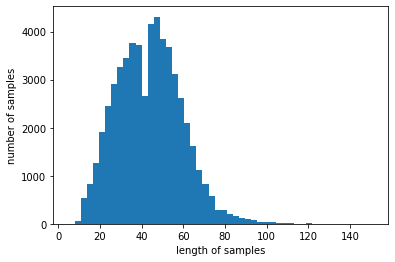

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 95.65565886502084


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train_data)
y_train = encoder.transform(y_train_data)
y_train = to_categorical(y_train)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_test_data)
y_test = encoder.transform(y_test_data)
y_test = to_categorical(y_test)

In [ ]:
y_train, y_test

(array([[0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32))

In [ ]:
X_train.shape

(56142, 70)

In [ ]:
total_cnt

3771

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64
hidden_units = 64
num_classes = 6

model = Sequential()
model.add(Embedding(total_cnt, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))
chkpoint_filepath = "/content/drive/MyDrive/sentiment_analysis.h5"

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 3)
mc = ModelCheckpoint(filepath = chkpoint_filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.25, verbose = 1)

Epoch 1/50
658/658 [==============================] - ETA: 0s - loss: 1.7910 - accuracy: 0.1782
Epoch 1: val_accuracy improved from -inf to 0.17904, saving model to /content/drive/MyDrive/sentiment_analysis.h5
658/658 [==============================] - 53s 72ms/step - loss: 1.7910 - accuracy: 0.1782 - val_loss: 1.7912 - val_accuracy: 0.1790
Epoch 2/50
658/658 [==============================] - ETA: 0s - loss: 1.7796 - accuracy: 0.2046
Epoch 2: val_accuracy did not improve from 0.17904
658/658 [==============================] - 46s 71ms/step - loss: 1.7796 - accuracy: 0.2046 - val_loss: 1.8023 - val_accuracy: 0.1666
Epoch 3/50
658/658 [==============================] - ETA: 0s - loss: 1.7307 - accuracy: 0.2572
Epoch 3: val_accuracy did not improve from 0.17904
658/658 [==============================] - 47s 71ms/step - loss: 1.7307 - accuracy: 0.2572 - val_loss: 1.8430 - val_accuracy: 0.1651
Epoch 4/50
658/658 [==============================] - ETA: 0s - loss: 1.6660 - accuracy: 0.3035
E

In [ ]:
fig, loss_ax = plt.subplots(figsize=(8, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

2. 여기서부터는 Logistic Regression을 활용하여 감정 예측 => TfidfVectorize로 벡터화
감정 분류 방법
  
 1) 행복 기쁨 / 분노 / 불안 당황 / 슬픔 상처
 2) 행복 기쁨 / 분노 불안 당황 / 슬픔 상처

In [ ]:
sentimential_list = {'행복' : 0, '기쁨': 0, '분노' : 1, '불안' : 1, '당황' : 2, '슬픔' : 2, '상처' : 2}
train_df['label'] = train_df['감정_대분류'].map(sentimential_list)
train_df.head()

감정_대분류                                              사람문장1  \
0     기쁨                                    지금 난 기분이 너무 좋아.   
1     기쁨                                  나도 조카가 생겨! 너무 기뻐.   
2     불안                            거래처와의 다음 계약이 무산될까봐 불안해.   
3     슬픔  당뇨로 고생 중인데 아내가 이혼하자더군. 아내가 날 버리면 병은 더 악화될 텐데 세...   
4     슬픔                        노년에 재정적으로 이루어 놓은게 없어서 걱정이야.   

                                      시스템응답1  \
0                굉장히 즐거우신 것 같은데요? 좋은 일이 있나요?   
1             정말 좋은 소식이네요. 축하할 특별한 계획이 있을까요?   
2  많이 걱정되시겠어요. 계약이 무산될 것 같다고 생각하는 이유가 있으신가요?   
3  몸이 아픈데 아내가 이혼하자고 하니 혼자 있는 것 같은 기분을 느끼셨군요.   
4                   나이들어 재정적으로 어려워서 걱정되시는군요.   

                                      사람문장2                          시스템응답2  \
0               오늘부터 연휴가 시작됐거든. 내일 회사 안 간다.  그거 정말 기분 좋을 만하네요. 무엇을 할 예정인가요?   
1     응. 언니에게 꽃다발을 선물할 거야. 예쁜 딸이면 좋을 것 같아서.            언니에게 꽃을 선물하려고 하시는군요.   
2               딱히 이유는 없어. 그냥 나 혼자 불안한 상태야.     계약을 성공적으로 마무리하실 수 있기를 기원해요.   
3  젊은 시절에 가정에 소홀했지. 그래도 그렇지 이혼을 하자니 너무 허망해.   지금의 기분에서 벗어나기 위해 무엇을 하면 좋을까요?   
4                                 정말이지 막막해.   막막한 현실이지만 분명 해결책을 찾을 수 있을거예요.   

                                               사람문장3  \
0                        그냥 집에서 뒹굴뒹굴하고 넷플릭스 보고 놀 거야.   
1                                                      
2                                                      
3  아내에게 졸혼은 어떤지 대화를 나누어 봐야겠어. 졸혼을 한다면 가끔씩이라도 도움을 ...   
4                                                      

                          시스템응답3  label  \
0  집에서 노는 것이 최고죠. 생각만 해도 행복하겠어요.      0   
1                                     0   
2                                     1   
3       아내와의 대화로 기분이 나아졌으면 좋겠어요.      2   
4                                     2   

                                                text  
0  지금 난 기분이 너무 좋아 굉장히 즐거우신 것 같은데요 좋은 일이 있나요 오늘부터 ...  
1  나도 조카가 생겨 너무 기뻐 정말 좋은 소식이네요 축하할 특별한 계획이 있을까요 응...  
2  거래처와의 다음 계약이 무산될까봐 불안해 많이 걱정되시겠어요 계약이 무산될 것 같다...  
3  당뇨로 고생 중인데 아내가 이혼하자더군 아내가 날 버리면 병은 더 악화될 텐데 세상...  
4  노년에 재정적으로 이루어 놓은게 없어서 걱정이야 나이들어 재정적으로 어려워서 걱정되...

In [ ]:
x_data =  train_df['text'].apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', " ", x)).values
y_data = train_df['감정_대분류']

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_data)
y_data_encoded = encoder.transform(y_data)
y_data = to_categorical(y_data_encoded) 

In [ ]:
y_data.shape

(74358, 6)

In [ ]:
x_data.shape

(74358,)

In [ ]:
from konlpy.tag import Okt
import os
from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

In [ ]:
y_train[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [ ]:
tokenizer.word_index['너무']

1

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 178552
등장 빈도가 2번 이하인 희귀 단어의 수: 126609
단어 집합에서 희귀 단어의 비율: 70.90875487253014
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.420796009819453


In [ ]:
vocab_size = tokenizer.word_index
len(vocab_size)

178552

In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 51944


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(x_train)
x_train_okt = tokenizer.texts_to_sequences(x_train)
x_test_okt = tokenizer.texts_to_sequences(x_test)

리뷰의 최대 길이 : 119
리뷰의 평균 길이 : 37.10999226708805


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


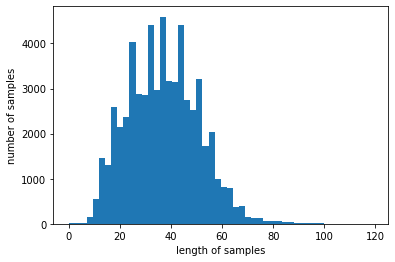

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in x_train_okt))
print('리뷰의 평균 길이 :',sum(map(len, x_train_okt))/len(x_train_okt))
plt.hist([len(review) for review in x_train_okt], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, x_train_okt)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 95.4056416635847


In [ ]:
x_train_okt = pad_sequences(x_train_okt, maxlen=max_len)
x_test_okt = pad_sequences(x_test_okt, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 60
hidden_units = 128
num_classes = 6

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(num_classes, activation='softmax'))
chkpoint_filepath = "/content/drive/MyDrive/best_model.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
mc = ModelCheckpoint(filepath = chkpoint_filepath,monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
history = model.fit(x_train_okt, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2, verbose = 1)

Epoch 1/50
744/744 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.3787
Epoch 1: val_loss improved from inf to 1.23932, saving model to /content/drive/MyDrive/best_model.h5
744/744 [==============================] - 161s 211ms/step - loss: 1.4575 - accuracy: 0.3787 - val_loss: 1.2393 - val_accuracy: 0.5332
Epoch 2/50
744/744 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.6802
Epoch 2: val_loss improved from 1.23932 to 1.00390, saving model to /content/drive/MyDrive/best_model.h5
744/744 [==============================] - 155s 208ms/step - loss: 0.9085 - accuracy: 0.6802 - val_loss: 1.0039 - val_accuracy: 0.6561
Epoch 3/50
744/744 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.8129
Epoch 3: val_loss did not improve from 1.00390
744/744 [==============================] - 152s 205ms/step - loss: 0.5724 - accuracy: 0.8129 - val_loss: 1.0420 - val_accuracy: 0.6481
Epoch 4/50
744/744 [==============================] - 

In [ ]:
#x_test, y_test 해보기

1. 각 문장마다 어떤 정확도를 보이는 지 확인해보기

In [ ]:
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [ ]:
import os
from scipy.sparse import save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer

def transform_data(x_train, x_test):
  if not os.path.isfile('okt_train.npz'):
    tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
    tfidf.fit(x_train)
    x_train_okt = tfidf.transform(x_train)
    x_test_okt = tfidf.transform(x_test)
    save_npz('okt_train.npz', x_train_okt)
    save_npz('okt_test.npz', x_test_okt)
  else:
    x_train_okt = load_npz('okt_train.npz')
    x_test_okt = load_npz('okt_test.npz')

    return x_train_okt, x_test_okt

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
import time

def light_gbm_train(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
  lgbm_clf.fit(x_train_okt, y_train)
  preds = lgbm_clf.predict(x_test_okt)
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')
  print('LGBM Classifier accuracy score : ', accuracy_score(y_test, preds))
  print("LGBM Classifier\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('LGBM Classifier 분류 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

def LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  clf = LogisticRegression(max_iter = 1000, random_state = 0)
  clf.fit(x_train_okt, y_train)
  preds = clf.predict(x_test_okt)
  print('LogisticRegression accuracy score : ', accuracy_score(y_test, preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic Regression general set\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1)) 
  print('Logistic Regression 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import time

def LogisticRegression_liblinear(x_train_okt, x_test_okt, y_train, y_test):
  start = time.time()
  clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
  clf.fit(x_train_okt, y_train)
  preds = clf.predict(x_test_okt)
  print('LogisticRegression_liblinear accuracy score : ', accuracy_score(y_test,  preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic Regression liblinear")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('Logistic Regression liblinear 걸린 시간 : ', time.time() - start)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import time

def Logistic_with_CountVectorizer(x_data, y_data):
  start = time.time()
  count_vec = CountVectorizer(tokenizer = okt.morphs)
  x_train_data = count_vec.fit_transform(x_data)
  x_train, x_test, y_train, y_test = train_test_split(x_train_data, y_data, test_size = 0.25, random_state = 156)
  clf = LogisticRegression(max_iter = 1000, solver = 'liblinear',)
  clf.fit(x_train, y_train)
  preds = clf.predict(x_test)
  print('Logistic with CountVectorizer accuracy score : ', accuracy_score(y_test, preds))
  confusion = confusion_matrix(y_test, preds)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds, average='weighted')
  recall = recall_score(y_test, preds, average='weighted')
  f1 = f1_score(y_test, preds, average='weighted')

  print("Logistic with CountVectorizer\n")
  print(confusion)
  print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'
        .format(accuracy,precision,recall,f1))
  print('Logistic with CountVectorizer 걸린 시간 : ', time.time() - start)

In [ ]:
load_npz('okt_train.npz')

In [ ]:
from konlpy.tag import Okt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from scipy.sparse import save_npz, load_npz


'''train_df['text'] = train_df['사람문장1'] + train_df['시스템응답1'] + train_df['사람문장2'].map(str) + train_df['시스템응답2'] + train_df['사람문장3'] + train_df['시스템응답3']
x_data =  train_df['text'].apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', " ", x)).values
y_data = train_df['label']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify = y_data, test_size = 0.25, random_state = 42)

okt = Okt()

if not os.path.isfile('second_train.npz'):
  tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
  tfidf.fit(x_train)
  x_train_okt = tfidf.transform(x_train)
  x_test_okt = tfidf.transform(x_test)
  save_npz('second_train.npz', x_train_okt)
  save_npz('second_test.npz', x_test_okt)
else:
  x_train_okt = load_npz('second_train.npz')
  x_test_okt = load_npz('second_test.npz')'''

print('===================전체 정확도=================')
light_gbm_train(X_train, X_test, y_train, y_test)
LogisticRegression_train(X_train, X_test, y_train, y_test)
LogisticRegression_liblinear(X_train, X_test, y_train, y_test)
#Logistic_with_CountVectorizer(x_data, y_data)

In [ ]:
text = ["나 진짜 너 오늘 죽여버림 ㅋ", "그 영화 진짜 너무 재밌었던 것 같아서 행복해",
        "요즘 인생 현타 겁나 옴 ㅋ", "나 오늘 시험 100점 맞을 겨", "짜증나", "나는 뭘 해도 안될거야", "너 때문에 내가 지금 너무 빡친다"]
clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
clf.fit(x_train_okt, y_train)
score = clf.predict(tfidf.transform(text))
print(score)
print(clf.predict_proba(tfidf.transform(text)))

In [ ]:
test_df = pd.read_excel('/content/test_data.xlsx')
test_df.head()

In [ ]:
test_df.info()

In [ ]:
test_df.fillna('', inplace = True)

In [ ]:
sentimential_list = {'행복' : 0, '기쁨': 0, '분노' : 1, '불안' : 1, '당황' : 2, '슬픔' : 2, '상처' : 2}
test_df['label'] = test_df['감정_대분류'].map(sentimential_list)

NameError: ignored

In [ ]:
test_df['text'] = test_df['사람문장1'] + test_df['시스템응답1'] + test_df['사람문장2'].map(str) + test_df['시스템응답2'] + test_df['사람문장3'] + test_df['시스템응답3']
test_df.head()

NameError: ignored

In [ ]:
start = time.time()
clf = LogisticRegression(max_iter = 1000, random_state = 0, solver = "liblinear", C = 3)
clf.fit(x_train_okt, y_train)
score = clf.predict(tfidf.transform(test_df['text']))
test_df['prediction'] = score
test_df['result'] = test_df['label'] - test_df['prediction']
print('전체 정확도는 : ', end = ' ')
print(len(test_df[test_df['result'] == 0]) / len(test_df['result']))
print('걸린 시간 : ', time.time() - start)
print("========================")

In [ ]:
start = time.time()
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
score = lgbm_clf.predict(tfidf.transform(test_df['text']))
test_df['LGB_prediction'] = score
test_df['LGB_result'] = test_df['label'] - test_df['LGB_prediction']
print('LGBM 전체 정확도는 : ', end = ' ')
print(len(test_df[test_df['LGB_result'] == 0]) / len(test_df['result']))
print('걸린 시간 : ', time.time() - start)

In [ ]:
print(len(test_df[test_df['result'] == 0]) / len(test_df['result']))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df = 5).fit(x_data)

In [ ]:
import re
#train_df['text'] = train_df['사람문장1'] + train_df['시스템응답1'] + train_df['사람문장2'].map(str) + train_df['시스템응답2'] + train_df['사람문장3'] + train_df['시스템응답3']
x_data = train_df['text']
y_data = train_df['label']

x_data = x_data.apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', " ", x)).values
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify = y_data, test_size = 0.25, random_state = 42)

from konlpy.tag import Okt

okt = Okt()
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
tfidf.fit(x_train)
x_train_okt = tfidf.transform(x_train)
x_test_okt = tfidf.transform(x_test)
print('=======text를 다 합치면=======')
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
preds = lgbm_clf.predict(x_test_okt)
confusion = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted')
recall = recall_score(y_test, preds, average = 'weighted')
f1 = f1_score(y_test, preds, average = 'weighted')

print("LGBM Classifier\n")
print(confusion)
print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'.format(accuracy,precision,recall,f1))#LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test)
#LogisticRegression_liblinear(x_train_okt, x_test_okt, y_train, y_test)
#Logistic_with_CountVectorizer(x_data, y_data)

=======text를 다 합치면=======
LGBM Classifier

[[ 2647    34   431]
 [   38  1794  1294]
 [  176   363 11937]]
정확도: 0.8752
정밀도: 0.8731
재현율: 0.8752
f1: 0.8690


In [ ]:
print('=======text를 다 합치면=======')
lgbm_clf = LGBMClassifier(n_estimators = 400, n_jobs = -1, verbose = 1)
lgbm_clf.fit(x_train_okt, y_train)
preds = lgbm_clf.predict(x_test_okt)
confusion = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted')
recall = recall_score(y_test, preds, average = 'weighted')
f1 = f1_score(y_test, preds, average = 'weighted')

print("LGBM Classifier\n")
print(confusion)
print('정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nf1: {3:.4f}'.format(accuracy,precision,recall,f1))#LogisticRegression_train(x_train_okt, x_test_okt, y_train, y_test)

=======text를 다 합치면=======
LGBM Classifier

[[ 2647    34   431]
 [   38  1794  1294]
 [  176   363 11937]]
정확도: 0.8752
정밀도: 0.8731
재현율: 0.8752
f1: 0.8690


In [ ]:
text = ["나 진짜 너 오늘 죽여버림 ㅋ", "그 영화 진짜 너무 재밌었던 것 같아서 행복해",
        "요즘 인생 현타 겁나 옴 ㅋ", "나 오늘 시험 100점 맞을 겨"]
score = lgbm_clf.predict(tfidf.transform(text))
print(score)
print(lgbm_clf.predict_proba(tfidf.transform(text)))

In [ ]:
if not os.path.isfile('okt_train.npz'):
  tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3, max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)
  tfidf.fit(x_train)
  x_train_okt = tfidf.transform(x_train)
  x_test_okt = tfidf.transform(x_test)
  save_npz('okt_train.npz', x_train_okt)
  save_npz('okt_test.npz', x_test_okt)
else:
  x_train_okt = load_npz('okt_train.npz')
  x_test_okt = load_npz('okt_test.npz')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(max_iter = 1000, random_state = 0)
params = {'C' : [0.01, 0.1, 0.5,  1, 5, 10]}
grid_cv = GridSearchCV(clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv.fit(x_train_okt, y_train)

print(grid_cv.best_params_, grid_cv.best_score_)

In [ ]:
count_vec.vocabulary_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.utils.fixes import loguniform

sgd = SGDClassifier(loss = 'log', random_state = 42)
param_dist = {'alpha' : loguniform(0.0001, 100.0)}

rsv_okt = RandomizedSearchCV(estimator = sgd, param_distributions = param_dist,
                             n_iter = 50, random_state = 42, verbose = 1)
rsv_okt.fit(x_train_okt, y_train)

In [ ]:
print(rsv_okt.best_score_)
print(rsv_okt.best_params_)